In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import sparse
from sklearn.metrics import mean_squared_error as MSE
import time

import keras
from keras.models import Sequential
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

from utils import load_Lie_weights

Using TensorFlow backend.


Let's define Airbus benchmarking solution:

In [2]:
def phi(t, x):
    return np.exp(-(x-4*t)**2/(4*nu*(t+1))) + np.exp(-(x-4*t-2*np.pi)**2/(4*nu*(t+1)))

def phi_x(t, x):
    return np.exp(-(x-4*t)**2/(4*nu*(t+1)))*(-2*(x-4*t)/(4*nu*(t+1))) +\
     np.exp(-(x-4*t-2*np.pi)**2/(4*nu*(t+1)))*(-2*(x-4*t-2*np.pi)/(4*nu*(t+1)))

def u_analytic(t, x):
    return (-2*nu*phi_x(t, x)/phi(t, x)+4)

and use the traditional FDM method

In [3]:
dx = 2*np.pi/1000
dt = 2.5e-4

nu=0.05

In [4]:
def FDM(ui):
    u0 = ui[:-2]
    u1 = ui[1:-1]
    u2 = ui[2:]
    return u1 + dt*(-u1*(u1-u0)/dx + nu*(u2-2*u1+u0)/dx**2)

In [5]:
x = np.arange(0, 2*np.pi, dx)
t = np.arange(dt, 0.5+dt, dt)

# calc analytic solution:
u_prec = np.empty((t.shape[0], x.shape[0]))
u_prec[0] = u_analytic(0, x)
for i in xrange(1, t.shape[0]):
    u_prec[i] = u_analytic(t[i], x)

# prepare mesh with initial and boundary conditions:
u0 = u_analytic(0, x)
u_num = np.empty((t.shape[0], x.shape[0]))
u_num[0] = u_analytic(0, x)
u_num[:, 0] = u_analytic(t, x[0])
u_num[:, -1] = u_analytic(t, x[-1])

print 'FDM mesh:', u_num.shape


start = time.time()
for i in xrange(1, t.shape[0]):
    u_num[i, 1:-1] = FDM(u_num[i-1])

print 'elapsed time:', time.time()-start

print 'MSE error:', MSE(u_num[-1], u_prec[-1])

FDM mesh: (2000, 1000)
elapsed time: 0.0551960468292
MSE error: 0.08039678693753491


Now let's define a lie map for the Burgers' equation:

In [6]:
# calculate a linear part of the matrix Lie map
def get_lie_map(N, dt):
    M = np.zeros((N*2, N*2))
    I = np.eye(N)
    M[:N, :N] = I
    M[:N, N:] = I*dt
    M[N:, N:] = I

    U = np.zeros((N, N))
    U[0, 0:3] = np.array([1., -2., 1.])/2
    U[1, 0:4] = np.array([2., -3., 0,  1.])/4
    U[-2, -4:] = np.array([1., 0, -3., 2.])/4
    U[-1, -3:] = np.array([1., -2., 1.])/2
    for i in xrange(2, N-2):
        U[i, i-2:i+3] = np.array([1.0, 0, -2, 0, 1.])/4

    M[N:, N:] += dt*U*nu/dx**2
    return M

In [7]:
dt_lie = 1e-3
N = 2*x.shape[0]
W = [np.zeros(N).reshape((1, N)), get_lie_map(N/2, dt_lie).T]

#define a neural network:
map_Lie = LieLayer(output_dim = N, order = 1, input_shape = (N,))
lie_net = Sequential()
lie_net.add(map_Lie)
map_Lie.set_weights(W)
print lie_net

Instructions for updating:
Colocations handled automatically by placer.


Now we can start the simulation with Lie--based neural network:

In [8]:
x = np.arange(0, 2*np.pi, dx)
t = np.arange(dt_lie, 0.5+dt_lie, dt_lie)

# prepare mesh with initial and boundary conditions:
u_lie = np.empty((t.shape[0], x.shape[0]))
u_lie[0] = u_analytic(0, x)
u_lie[:, 0] = u_analytic(t, x[0])
u_lie[:, -1] = u_analytic(t, x[-1])

print 'Lie mesh:', u_lie.shape

xu = np.empty((1, N))
xu[0, :N/2] = x

start = time.time()
for i in xrange(1, t.shape[0]):
    xu[0, 1000:] = u_lie[i-1]
    xun = lie_net.predict(xu)
    un = np.interp(x, xun[0, :1000], xun[0, 1000:])
    u_lie[i, 1:-1] = un[1:-1]

print 'elapsed time (without optimization):', time.time()-start

print 'MSE error:', MSE(u_lie[-1], u_prec[-1])

Lie mesh: (500, 1000)
elapsed time (without optimization): 0.924559116364
MSE error: 0.005509831633503308


Since the current implementation of Lie layer is not optimized for TensorFlow, the computational time is big enough. For more precise computational performance estimation, we can implement matrix Lie map as a sparse matrix transformation.

In [9]:
M = sparse.csr_matrix(get_lie_map(N/2, dt_lie))

xu = np.empty((2000))
xu[:1000] = x

start = time.time()
for i in xrange(1, t.shape[0]):
    xu[1000:] = u_lie[i-1]
    xun = M.dot(xu)
    un = np.interp(x, xun[:1000], xun[1000:])
    u_lie[i, 1:-1] = un[1:-1]
    
print 'Lie mesh:', u_lie.shape
print 'elapsed time (with optimization):', time.time()-start
print 'MSE error:', MSE(u_lie[-1], u_prec[-1])

Lie mesh: (500, 1000)
elapsed time (with optimization): 0.0162060260773
MSE error: 0.005509822400274407


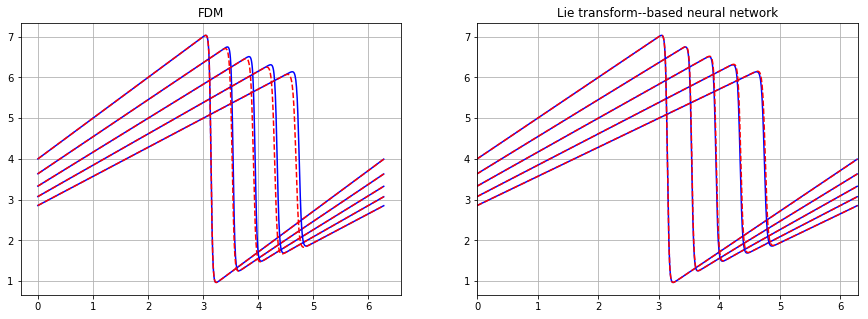

In [10]:
#plot the results
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

step = int(0.1/dt) # plot each 0.1 sec
for ua, un in zip(u_prec[::step], u_num[::step]):
    ax[0].plot(x, ua, 'b')
    ax[0].plot(x, un, 'r--')

step_lie = int(0.1/dt_lie)
for ua, un in zip(u_prec[::step], u_lie[::step_lie]):
    ax[1].plot(x, ua, 'b')
    ax[1].plot(x, un, 'r--')

ax[0].set_title('FDM')
ax[1].set_title('Lie transform--based neural network')

    
for i in [0,1]:
    ax[i].grid()
plt.xlim([0, 2*np.pi])
plt.show()